### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")

Загрузим пользователей и списки последних прочитанных новостей

Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [3]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [4]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('stopwords.txt', encoding='utf8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

808

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\COSMOT~1\AppData\Local\Temp/ipykernel_8624/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 32.4 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 52s


А теперь в 3 строчки обучим нашу модель

In [10]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, век, ...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, назад, территория, современный, испания...
Name: title, Length: 27000, dtype: object

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [12]:
from gensim.models import LdaModel

n_topics=25

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=n_topics, id2word=common_dictionary, random_state=13)#, passes=10)

Wall time: 1min


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(6, 0.035685685), (7, 0.052592706), (10, 0.8871591)]

In [16]:
x=lda.show_topics(num_topics=n_topics, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия российский рубль рынок развитие проект банк
topic_1: гражданин россиянин мэй народный фронт визовый комплексный
topic_2: газ сша пациент американский исследование рак товар
topic_3: взрыв иск преступление сын помещение приговор отец
topic_4: экипаж авария планета сократиться кг вес су
topic_5: писать путин пресссекретарить владимир песок подсчитать пилотировать
topic_6: соглашение новый сигнал источник сторона проект вопрос
topic_7: ребёнок погибнуть район квартира область следствие территория
topic_8: рост система регион автор объект область доля
topic_9: мозг тело новый причина болезнь день произойти
topic_10: хороший очень большой рейс метод ниже каждый
topic_11: москва выяснить россия обнаружить день фонд смерть
topic_12: рост фонд цена составить производитель показатель вырасти
topic_13: военный сша россия российский земля северный миссия
topic_14: китай высота налог китайский остров вода бизнесмен
topic_15: исследование управлять анализ фильм пища лаборатория необ

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(n_topics):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(n_topics)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(n_topics)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.421355,0.0,0.0,0.000000,0.0,0.0,0.376893,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.082097,0.0,0.0
1,4896,0.000000,0.0,0.0,0.537723,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,4897,0.000000,0.0,0.0,0.000000,0.0,0.0,0.035718,0.052677,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,4898,0.202132,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,4899,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.036833,...,0.0,0.0,0.0,0.0,0.0,0.814954,0.0,0.000000,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(n_topics)]].values))

In [21]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.06813878, 0.        ,
       0.1050953 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02319068, 0.        , 0.05860378,
       0.        , 0.33024657, 0.        , 0.13341899, 0.        ,
       0.14275153, 0.        , 0.12660661, 0.        , 0.        ])

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.11884142, 0.00240493, 0.01177516, 0.        , 0.00505683,
       0.04287232, 0.03628069, 0.03366578, 0.02897274, 0.0724159 ,
       0.00662162, 0.13405844, 0.00889017, 0.10677979, 0.        ,
       0.        , 0.0541253 , 0.        , 0.04697397, 0.        ,
       0.        , 0.20806504, 0.01326147, 0.05490871, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [24]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(n_topics)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(n_topics)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.074232,0.0,0.000000,0.026200,0.0,0.017516,0.051632,0.045730,0.097925,...,0.000000,0.083228,0.0,0.151257,0.0,0.050484,0.011554,0.067067,0.000000,0.019361
1,u108690,0.081130,0.0,0.006454,0.011870,0.0,0.014609,0.063825,0.031293,0.012000,...,0.005163,0.018681,0.0,0.154204,0.0,0.054983,0.131781,0.054497,0.058869,0.007892
2,u108339,0.055605,0.0,0.028274,0.023135,0.0,0.003190,0.017645,0.058730,0.048946,...,0.000000,0.014906,0.0,0.115582,0.0,0.076182,0.074840,0.047780,0.012229,0.001764


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [25]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
def fit_and_preds(n=n_topics, weights_only=False):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(n)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(n)]]
    target = pd.read_csv("users_churn.csv")
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(n)]], 
                                                        X['churn'], random_state=13)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    if weights_only:
        return logreg.coef_
    else:
        preds = logreg.predict_proba(X_test)[:, 1]
        return preds, y_test

preds, y_test = fit_and_preds()

In [28]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [29]:
import itertools

In [30]:
def metrics(return_tres=True):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    if return_tres:
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
        return thresholds[ix]
    else:
        return roc_auc_score(y_test, preds), precision[ix], recall[ix], fscore[ix]
    
threshold = metrics()

Best Threshold=0.287709, F-Score=0.712, Precision=0.720, Recall=0.704


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1669   71]
 [  78  182]]


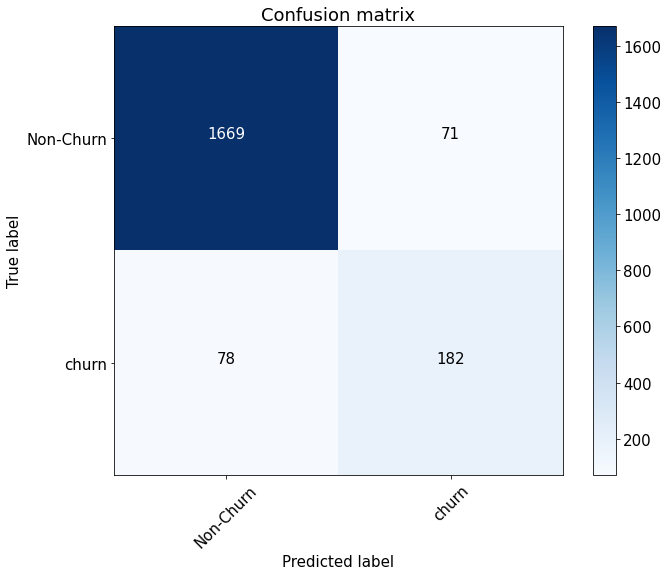

In [32]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [33]:
roc_auc_score(y_test, preds)

0.9544164456233422

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

# Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [34]:
res = pd.DataFrame(index=['mean', 'median', 'max'], columns=['roc_auc', 'precision', 'recall', 'fscore'])
res.loc['mean'] = metrics(False)

## Median

In [35]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [36]:
preds, y_test = fit_and_preds()
res.loc['median'] = metrics(False)

## Max

In [37]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [38]:
preds, y_test = fit_and_preds()
res.loc['max'] = metrics(False)

## Итоги

In [39]:
res

,roc_auc,precision,recall,fscore
mean,0.954416,0.720472,0.703846,0.712062
median,0.983499,0.765677,0.892308,0.824156
max,0.970769,0.78022,0.819231,0.79925


Подход к построению embedding через среднее показал наихудший результат, вариант с max - самый лучший, он точнее всего определяет темы, интересующие клиентов, которые потенциально покинут портал. В данном случае нам важнее всего показатель precision.
Среднее слишком сглаживает результат, не удается точно определить заинтересованность темой, т.к. в результат вмешиваются статьи, к теме не относящиеся, или слабо относящиеся. Максимум позволяет выбирать наиболее информативные с точки зрения реперезентации темы статьи.

## TfIdf

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
joined_texts = [' '.join(t) for t in news['title']]
vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.8)   # дополнительно отбросим очень редкие и очень популярные слова
tfidf_matrix = vectorizer.fit_transform(joined_texts).toarray()
tfidf_docdict = dict(zip(news['doc_id'].values,[i for i in tfidf_matrix]))

In [42]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([tfidf_docdict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

Best Threshold=0.318786, F-Score=0.994, Precision=1.000, Recall=0.988
Confusion matrix, without normalization
[[1738    2]
 [   3  257]]


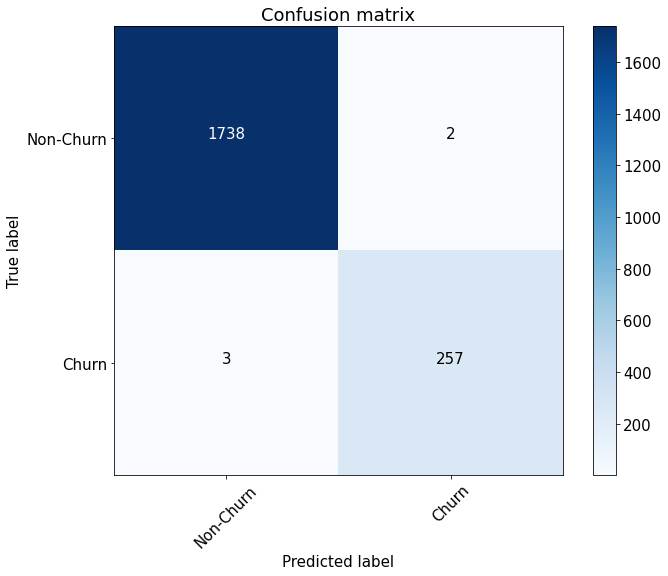

In [43]:
preds, y_test = fit_and_preds(n=tfidf_matrix.shape[1])
treshold=metrics()
cnf_matrix = confusion_matrix(y_test, preds>threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'Сhurn'],
                      title='Confusion matrix')
plt.show()

Получилось даже лучше, чем в варианте с LDA, по всем метрикам.

Посмотрим, какие слова встречались чаще и тех, кто ушел, и кто остался.

In [44]:
words_idx_sorted = fit_and_preds(n=tfidf_matrix.shape[1], weights_only=True).reshape(-1,).argsort()

In [45]:
np.array(vectorizer.get_feature_names())[words_idx_sorted[-10:][::-1]]    # ушли

array(['украина', 'украинский', 'рф', 'задержать', 'день', 'пострадать',
       'ребёнок', 'женщина', 'мужчина', 'сотрудник'], dtype='<U17')

In [46]:
np.array(vectorizer.get_feature_names())[words_idx_sorted[:10]]    # остались

array(['интерфакс', 'ссылка', 'сайт', 'партия', 'риа', 'писать',
       'состояться', 'премьерминистр', 'тысяча', 'новость'], dtype='<U17')